In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

from torch.nn.parameter import Parameter
import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat
#Set default dtype to float32
torch.set_default_dtype(torch.float)

from smt.sampling_methods import LHS
#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

In [2]:
data = scipy.io.loadmat('burgers_shock_10sin.mat')
label = "QCRE_2D_5_tanhxtanh_NW"
                     
x_test = data['x']                                   # 256 points between -1 and 1 [256x1]
t_test = data['t']   
usol = data['usol']
X_test, T_test = np.meshgrid(x_test,t_test)  

xt_test_tensor = torch.from_numpy(np.hstack((X_test.flatten()[:,None], T_test.flatten()[:,None]))).float().to(device)

u_true = usol.flatten('F')[:,None]/5

In [3]:
# data = scipy.io.loadmat('burgers_shock_10sin.mat')  	# Load data from file

pi = torch.from_numpy(np.array(np.pi)).double().to(device)

label = "QCRE_2D_5_tanhxtanh_NW"
# x = data['x']                                   # 256 points between -1 and 1 [256x1]
# t = data['t']                                   # 100 time points between 0 and 0.2 [100x1] 
# usol = data['usol']   

#usol = usol/1000# solution of 256x100 grid points
x_ll = -1*np.sqrt(np.pi/0.05)
x_ul = np.sqrt(np.pi/0.05)

x = np.linspace(x_ll,x_ul,500).reshape(-1,1)
t = np.linspace(0,0.04,500).reshape(-1,1)

X,T = np.meshgrid(x,t)

X = X.flatten('F').reshape(-1,1)
T = T.flatten('F').reshape(-1,1)
  
xt = np.hstack((X,T))

#y_true = true_2D_1(xt)

bound_pts_1 = (X==x_ll).reshape(-1,)
xt_bound_1 = xt[bound_pts_1,:]
u_bound_1 = np.zeros((np.shape(xt_bound_1)[0],1))

bound_pts_2 = (X==x_ul).reshape(-1,)
xt_bound_2 = xt[bound_pts_2,:]
u_bound_2 = np.zeros((np.shape(xt_bound_2)[0],1))

bound_pts_3 = (T==0).reshape(-1,)
xt_bound_3 = xt[bound_pts_3,:]
u_bound_3 = -2*np.sin(np.sqrt(np.pi*0.05)*xt_bound_3[:,0].reshape(-1,1))
#u_bound_3 = -10*np.ones((np.shape(bound_pts_3)[0],1))


xt_bound = np.vstack((xt_bound_1,xt_bound_2,xt_bound_3))
u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3))


lb_xt = xt[0]
ub_xt = xt[-1]

In [ ]:
plt.plot(xt_bound_3[:,0],u_bound_3)

In [4]:
def trainingdata(N_u,N_f,seed):

    '''Boundary Conditions'''
    #Initial Condition -1 =< x =<1 and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]

#     #Boundary Condition x = -1 and 0 =< t =<1
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[-1,:][:,None]

#     #Boundary Condition x = 1 and 0 =< t =<1
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[0,:][:,None]

#     all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
#     all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    np.random.seed(seed)
    idx = np.random.choice(xt_bound.shape[0], N_u, replace=True) 

    X_u_train = xt_bound[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = u_bound[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    X_f_train = lb_xt + (ub_xt-lb_xt)*samples 
    
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train

In [5]:
#X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
X_u_test = xt_test_tensor
# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
#u_true = usol.flatten('F')[:,None]

"\n   Fortran Style ('F') flatten,stacked column wise!\n   u = [c1 \n        c2\n        .\n        .\n        cn]\n\n   u =  [25600x1] \n"

In [6]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        '''
        Alternatively:
        
        *all layers are callable 
    
        Simple linear Layers
        self.fc1 = nn.Linear(2,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,1)
        
        '''
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        self.beta = Parameter(1*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
        self.train_loss = []
        self.test_loss = []
        self.beta_val = []
        
        
    'foward pass'
    def forward(self,x):
         if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
         u_b = torch.from_numpy(ub_xt).float().to(device)
         l_b = torch.from_numpy(lb_xt).float().to(device)
        
            
         #preprocessing input 
         x = (x - l_b)/(u_b - l_b) #feature scaling
        
         #convert to float
         a = x.float()
                        
         '''     
         Alternatively:
        
         a = self.activation(self.fc1(a))
         a = self.activation(self.fc2(a))
         a = self.activation(self.fc3(a))
         a = self.fc4(a)
         
         '''
        
         for i in range(len(layers)-2):
                z = self.linears[i](a)
                #a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
                a = self.activation(z)
    
         a = self.linears[-1](a)   
            
        
         return a
                        
    def loss_BC(self,x,y):
                
        loss_u = self.loss_function(self.forward(x), y)
                
        return loss_u
    
    def loss_PDE(self, x_to_train_f,f_hat):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        u = self.forward(g)
                
        u_x_t = autograd.grad(u,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
                                
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(x_to_train_f.shape).to(device), create_graph=True)[0]
                                                            
        u_x = u_x_t[:,[0]]
        
        u_t = u_x_t[:,[1]]
        
        u_xx = u_xx_tt[:,[0]]
                                        
        f = u_t + 25*torch.sqrt(pi/0.05)*(self.forward(g))*(u_x) - u_xx 
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,x,y,x_to_train_f,f_hat):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f,f_hat)

        
        
        loss_val = loss_u + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
        
#         X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f,self.iter*32)
        
#         X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
#         X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
#         u_train = torch.from_numpy(u_train_np_array).float().to(device)
        
#     #u = torch.from_numpy(u_true).float().to(device)
#         f_hat = torch.zeros(X_f_train.shape[0],1).to(device)
        

        loss = self.loss(X_u_train, u_train, X_f_train,f_hat)
        
        self.train_loss.append(loss.cpu().detach().numpy())
        
        
        u_pred = self.test(xt_test_tensor)
        self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1))))
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
#         print(self.iter,"Train Loss",self.train_loss[-1])
        loss.backward()
        self.iter += 1
     
        return loss        
    'test neural network'
    
    def test(self,xt_test_tensor):
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

In [ ]:
xt_test_tensor

In [7]:
max_reps = 1

train_loss_full = []
test_loss_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))


for reps in range(max_reps):
    print(reps)
    N_u = 1000 #Total number of data points for 'u'
    N_f = 10000 #Total number of collocation points 
    
    X_f_train_np_array, X_u_train_np_array, u_train_np_array = trainingdata(N_u,N_f,reps*32)
        
    X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
    X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
        
    #u = torch.from_numpy(u_true).float().to(device)
    f_hat = torch.zeros(X_f_train.shape[0],1).to(device)
        

    #X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)
    'Convert to tensor and send to GPU'


    layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

    #layers = np.array([2,512,512,1])
    PINN = Sequentialmodel(layers)
       
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())


    'L-BFGS Optimizer'
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.5, 
                                  max_iter = 10000, 
                                  max_eval = None, 
                                  tolerance_grad = -1, 
                                  tolerance_change = -1, 
                                  history_size = 100, 
                                  line_search_fn = 'strong_wolfe')

    start_time = time.time()

    optimizer.step(PINN.closure)
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(PINN.train_loss)
    test_loss_full.append(PINN.test_loss)
    elapsed_time[reps] = time.time() - start_time
    beta_full.append(PINN.beta_val)
    

mdic = {"train_loss": train_loss_full,"test_loss": test_loss_full,"Time": elapsed_time, "beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0 Train Loss 46.862984 Test Loss 1.1229475350976041
1 Train Loss 39.6837 Test Loss 1.104391313548565
2 Train Loss 2.6311564 Test Loss 0.9968507977333643
3 Train Loss 1.2911766 Test Loss 0.9902607543677898
4 Train Loss 0.9595827 Test Loss 0.987743354942352
5 Train Loss 0.8778057 Test Loss 0.986663538

142 Train Loss 0.6254508 Test Loss 0.9574605800190656
143 Train Loss 0.6251563 Test Loss 0.9580685746311804
144 Train Loss 0.62447506 Test Loss 0.9583105503347524
145 Train Loss 0.6235154 Test Loss 0.9577133146010973
146 Train Loss 0.6227271 Test Loss 0.9572379036145331
147 Train Loss 0.6220853 Test Loss 0.9561331108224863
148 Train Loss 0.62128156 Test Loss 0.9559939208892959
149 Train Loss 0.620939 Test Loss 0.9563004755203254
150 Train Loss 0.62039816 Test Loss 0.9569338349880833
151 Train Loss 0.6199439 Test Loss 0.9578442925538653
152 Train Loss 0.61955225 Test Loss 0.960513435800379
153 Train Loss 0.6192317 Test Loss 0.9622452474369413
154 Train Loss 0.61911416 Test Loss 0.9633998295034005
155 Train Loss 0.6190339 Test Loss 0.9642652836765058
156 Train Loss 0.6189529 Test Loss 0.9651041239043542
157 Train Loss 0.6187041 Test Loss 0.9652457830648677
158 Train Loss 0.6180548 Test Loss 0.9659968280233158
159 Train Loss 0.6172009 Test Loss 0.9647974053917799
160 Train Loss 0.61577886

294 Train Loss 0.45394188 Test Loss 1.15581148849035
295 Train Loss 0.45342904 Test Loss 1.1453404855873561
296 Train Loss 0.45278907 Test Loss 1.1432636150337792
297 Train Loss 0.45256078 Test Loss 1.1412769599351085
298 Train Loss 0.4523866 Test Loss 1.1387158545805718
299 Train Loss 0.4522622 Test Loss 1.136887637542739
300 Train Loss 0.45218015 Test Loss 1.1352001774605562
301 Train Loss 0.45210573 Test Loss 1.1336507501315498
302 Train Loss 0.45195648 Test Loss 1.1314514946280967
303 Train Loss 0.4514012 Test Loss 1.1263982356255449
304 Train Loss 0.4501019 Test Loss 1.1162450417436662
305 Train Loss 0.44862002 Test Loss 1.1086475450076816
306 Train Loss 0.4467257 Test Loss 1.102610697383117
307 Train Loss 0.44409811 Test Loss 1.093393085468698
308 Train Loss 0.4418618 Test Loss 1.0873149147583785
309 Train Loss 0.43955344 Test Loss 1.07691008121982
310 Train Loss 0.43839395 Test Loss 1.0752257654651576
311 Train Loss 0.43751198 Test Loss 1.0759635129056546
312 Train Loss 0.436817

445 Train Loss 0.3758276 Test Loss 1.0309665522475142
446 Train Loss 0.37511382 Test Loss 1.02879407881074
447 Train Loss 0.37411377 Test Loss 1.0303090009365719
448 Train Loss 0.3730858 Test Loss 1.030254087315781
449 Train Loss 0.3710702 Test Loss 1.0365329255740554
450 Train Loss 0.37244698 Test Loss 1.0428578100084116
451 Train Loss 0.36998618 Test Loss 1.039502342258654
452 Train Loss 0.36905113 Test Loss 1.0423275789511912
453 Train Loss 0.3674264 Test Loss 1.053561819277955
454 Train Loss 0.36672783 Test Loss 1.0584089672021875
455 Train Loss 0.36546898 Test Loss 1.066367867988057
456 Train Loss 0.36450273 Test Loss 1.071434798642436
457 Train Loss 0.36385915 Test Loss 1.0728643458202656
458 Train Loss 0.36349896 Test Loss 1.0746190257811277
459 Train Loss 0.36332688 Test Loss 1.0740291836238884
460 Train Loss 0.3632612 Test Loss 1.0749614262436629
461 Train Loss 0.3631987 Test Loss 1.074441396426904
462 Train Loss 0.36316413 Test Loss 1.0741537587609862
463 Train Loss 0.3631352

597 Train Loss 0.31745002 Test Loss 1.0932157561355902
598 Train Loss 0.31728256 Test Loss 1.0931261310919138
599 Train Loss 0.31711632 Test Loss 1.0931287590346799
600 Train Loss 0.31695038 Test Loss 1.093833454088614
601 Train Loss 0.31677443 Test Loss 1.094495412557436
602 Train Loss 0.31663436 Test Loss 1.0960533500851048
603 Train Loss 0.316498 Test Loss 1.097225425103684
604 Train Loss 0.31639078 Test Loss 1.0983972206584918
605 Train Loss 0.3162196 Test Loss 1.099978431842313
606 Train Loss 0.31598276 Test Loss 1.1020427434800275
607 Train Loss 0.31564468 Test Loss 1.1043753856129102
608 Train Loss 0.3151424 Test Loss 1.1076044304043393
609 Train Loss 0.31454998 Test Loss 1.1105700487412253
610 Train Loss 0.31387252 Test Loss 1.1143246336630006
611 Train Loss 0.3134559 Test Loss 1.1165732321082817
612 Train Loss 0.3130216 Test Loss 1.1164596120257226
613 Train Loss 0.3129284 Test Loss 1.1180849192241678
614 Train Loss 0.31274918 Test Loss 1.1179044067368933
615 Train Loss 0.3125

748 Train Loss 0.2764203 Test Loss 1.1840210839449608
749 Train Loss 0.27638143 Test Loss 1.18583440995127
750 Train Loss 0.2763512 Test Loss 1.1872261312140124
751 Train Loss 0.27632576 Test Loss 1.188190975850815
752 Train Loss 0.27629676 Test Loss 1.189509043279696
753 Train Loss 0.27625597 Test Loss 1.1901809283157083
754 Train Loss 0.27621615 Test Loss 1.1908365155296894
755 Train Loss 0.27614674 Test Loss 1.1917264529126206
756 Train Loss 0.27607027 Test Loss 1.1924524296627752
757 Train Loss 0.27600017 Test Loss 1.192470009624621
758 Train Loss 0.27593836 Test Loss 1.1927512673276632
759 Train Loss 0.27586645 Test Loss 1.1926397830324185
760 Train Loss 0.27575475 Test Loss 1.193630240158402
761 Train Loss 0.27561218 Test Loss 1.193927438450369
762 Train Loss 0.2753826 Test Loss 1.1952656055150124
763 Train Loss 0.275029 Test Loss 1.1975115672552967
764 Train Loss 0.27464956 Test Loss 1.2008671858096047
765 Train Loss 0.27428827 Test Loss 1.2048579740984073
766 Train Loss 0.27400

900 Train Loss 0.25010094 Test Loss 1.222391126665109
901 Train Loss 0.25006613 Test Loss 1.2219942721444335
902 Train Loss 0.25003082 Test Loss 1.2221657044730143
903 Train Loss 0.25000003 Test Loss 1.222392382086832
904 Train Loss 0.24996664 Test Loss 1.222700607590341
905 Train Loss 0.24993399 Test Loss 1.2235720382720638
906 Train Loss 0.24990143 Test Loss 1.2236463853375912
907 Train Loss 0.24987634 Test Loss 1.2240342247562124
908 Train Loss 0.2498415 Test Loss 1.2240539690046366
909 Train Loss 0.24980411 Test Loss 1.2244049423694054
910 Train Loss 0.24976625 Test Loss 1.2245918257195678
911 Train Loss 0.24973188 Test Loss 1.224751397883508
912 Train Loss 0.24969347 Test Loss 1.2250993905467296
913 Train Loss 0.24965307 Test Loss 1.225269029157008
914 Train Loss 0.24958569 Test Loss 1.2258801386429878
915 Train Loss 0.24949755 Test Loss 1.2267322706766786
916 Train Loss 0.24934155 Test Loss 1.2298502617829292
917 Train Loss 0.24921466 Test Loss 1.231378418600198
918 Train Loss 0.

1054 Train Loss 0.23678614 Test Loss 1.2733631353390877
1055 Train Loss 0.236717 Test Loss 1.2732991385409986
1056 Train Loss 0.23662393 Test Loss 1.2735907991446154
1057 Train Loss 0.23652123 Test Loss 1.2739671310986909
1058 Train Loss 0.23640421 Test Loss 1.2760325505269896
1059 Train Loss 0.23630807 Test Loss 1.2778231525544335
1060 Train Loss 0.23624307 Test Loss 1.2784628047250286
1061 Train Loss 0.23619951 Test Loss 1.2791736058563132
1062 Train Loss 0.23616654 Test Loss 1.279125496253429
1063 Train Loss 0.23613553 Test Loss 1.2781904410858997
1064 Train Loss 0.23723713 Test Loss 1.2703414663049557
1065 Train Loss 0.23610386 Test Loss 1.2770240019544163
1066 Train Loss 0.23609091 Test Loss 1.2767172406306055
1067 Train Loss 0.23606569 Test Loss 1.2756645084376188
1068 Train Loss 0.23604831 Test Loss 1.2750463401711942
1069 Train Loss 0.23603627 Test Loss 1.274835259998786
1070 Train Loss 0.2360201 Test Loss 1.274744324483392
1071 Train Loss 0.23598658 Test Loss 1.275029277104766

1203 Train Loss 0.22896637 Test Loss 1.284419243292503
1204 Train Loss 0.22889732 Test Loss 1.2842789714944276
1205 Train Loss 0.22882572 Test Loss 1.2842669877826909
1206 Train Loss 0.22874251 Test Loss 1.2857625896840688
1207 Train Loss 0.22866939 Test Loss 1.2860027030965793
1208 Train Loss 0.2285647 Test Loss 1.2871377159362647
1209 Train Loss 0.22849691 Test Loss 1.2868753915496771
1210 Train Loss 0.22844224 Test Loss 1.2867902290344628
1211 Train Loss 0.22840902 Test Loss 1.2862046928017536
1212 Train Loss 0.22835305 Test Loss 1.285156846842889
1213 Train Loss 0.2282236 Test Loss 1.284662284936465
1214 Train Loss 0.22808719 Test Loss 1.2842242874404926
1215 Train Loss 0.227998 Test Loss 1.283134065417161
1216 Train Loss 0.22790472 Test Loss 1.283174881558579
1217 Train Loss 0.22784442 Test Loss 1.283788387465193
1218 Train Loss 0.2278103 Test Loss 1.284139887435362
1219 Train Loss 0.22778751 Test Loss 1.284929130622
1220 Train Loss 0.22776899 Test Loss 1.286314946355628
1221 Trai

1353 Train Loss 0.2231666 Test Loss 1.280225600647092
1354 Train Loss 0.22314763 Test Loss 1.2805750077067233
1355 Train Loss 0.2231147 Test Loss 1.280993787239832
1356 Train Loss 0.22308761 Test Loss 1.2810134355032554
1357 Train Loss 0.22306564 Test Loss 1.2810333211526939
1358 Train Loss 0.22305082 Test Loss 1.2808069970198872
1359 Train Loss 0.2230296 Test Loss 1.280886156353204
1360 Train Loss 0.22300173 Test Loss 1.2805669184183233
1361 Train Loss 0.22297642 Test Loss 1.2803270421817246
1362 Train Loss 0.22295295 Test Loss 1.280118236519432
1363 Train Loss 0.22291559 Test Loss 1.2806482719840901
1364 Train Loss 0.2228958 Test Loss 1.279770476605403
1365 Train Loss 0.2228537 Test Loss 1.2801527618958466
1366 Train Loss 0.22281842 Test Loss 1.2804730274559109
1367 Train Loss 0.22278827 Test Loss 1.2806220563790314
1368 Train Loss 0.22276747 Test Loss 1.2806638407673105
1369 Train Loss 0.2227459 Test Loss 1.280525538618756
1370 Train Loss 0.22272778 Test Loss 1.2803281800102742
1371

1504 Train Loss 0.2184074 Test Loss 1.2950307515358974
1505 Train Loss 0.21840316 Test Loss 1.295297683809283
1506 Train Loss 0.21839777 Test Loss 1.2956487930327518
1507 Train Loss 0.21839334 Test Loss 1.29591947984706
1508 Train Loss 0.21838737 Test Loss 1.296330948544093
1509 Train Loss 0.21837772 Test Loss 1.2969035310740364
1510 Train Loss 0.21836667 Test Loss 1.2975391977396353
1511 Train Loss 0.21835482 Test Loss 1.2980256011644153
1512 Train Loss 0.21834272 Test Loss 1.2983533905898839
1513 Train Loss 0.21852078 Test Loss 1.2986236582937378
1514 Train Loss 0.2183395 Test Loss 1.298379086311116
1515 Train Loss 0.21832523 Test Loss 1.2983861217543318
1516 Train Loss 0.21830034 Test Loss 1.2980836083959073
1517 Train Loss 0.21826336 Test Loss 1.296775404670871
1518 Train Loss 0.21823059 Test Loss 1.2954997669198185
1519 Train Loss 0.21819714 Test Loss 1.2938110231203115
1520 Train Loss 0.21816015 Test Loss 1.2923259024672515
1521 Train Loss 0.21810438 Test Loss 1.2915308320338317


KeyboardInterrupt: 

In [ ]:
PINN.W2

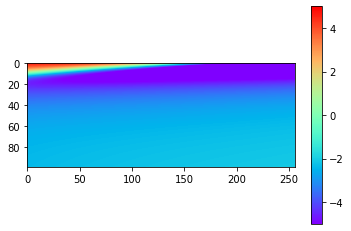

In [8]:
u_pred = PINN.test(xt_test_tensor)*5

cmap = plt.cm.rainbow
plt.imshow(u_pred.reshape(100,256),cmap = cmap,aspect =1,vmin=-5,vmax=5)
# plt.colorbar()

In [ ]:
X_u_train

In [ ]:
np.min(u_pred)

In [ ]:
np.max(u_pred)

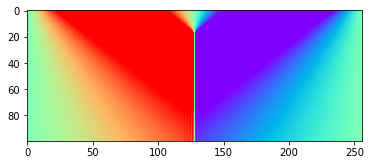

In [10]:
cmap = plt.cm.rainbow
plt.imshow(u_true.reshape(100,256)*5,cmap = cmap,aspect = 1,vmin=-5,vmax=5)

In [ ]:
np.min(u_true)

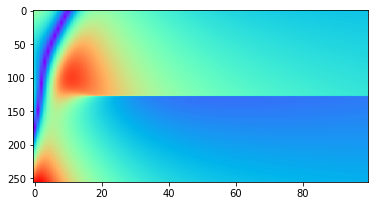

In [9]:
cmap = plt.cm.rainbow
plt.imshow(np.transpose(np.abs(u_pred - u_true).reshape(100,256)),cmap = cmap,aspect = 0.2)

In [ ]:
a = 0 
for i in range(10):
    print(test_loss_full[i][-1])
    a = a + test_loss_full[i][-1]
print(a/10)